# core

> Module for the least squares model fit.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from dataclasses import dataclass
from scipy.stats import t
import typing


Create an instance of the class `CalibrationModel` by passing in the path to both your calibration data and your sample data. Next specify the name of your response variable and the nummber of test replicates you measured.

In [ ]:
sns.set_style("white")
sns.set_style("ticks")

In [ ]:
#| export
class CalibrationModel:

# TODO: think about adding replicates and no. of calibration points here or read it automatically from data

    def __init__(self, data, sample_data, response_variable, test_replicates):
        self.raw_data = self.load_data(data)
        self.sample_data = self.load_sample_data(sample_data)
        self.response_variable = response_variable
        self.fit = None
        self.test_replicates = test_replicates
        self.cal_line_points = self.raw_data.shape[0]
        self.r2 = None 

    def load_data(self, data):
        if ".csv" in data:
            raw_data = pd.read_csv(data)
        else:
            raw_data = data

        return raw_data

    def load_sample_data(self, sample_data):
        if ".csv" in sample_data:
            sample_data = pd.read_csv(sample_data, index_col=0)

        return sample_data

    
    def plot_fit(self):
        sns.regplot(x="concentration", y=self.response_variable, data=self.raw_data)
        sns.despine()
        sns.set_context("paper")
        plt.title(f"Calibration curve of concentration versus {self.response_variable}")
        plt.xlabel("Concentration") 
        plt.show()

    def fit_ols(self):
        self.fit = smf.ols(f"{self.response_variable} ~ concentration", data=self.raw_data).fit()
        self.r2 = self.fit.rsquared
        print(self.fit.summary())
        return self.fit 
    
    def get_params(self):
        slope = self.fit.params[1]
        intercept = self.fit.params[0]
        return slope, intercept
    
    def get_r2(self):
        return self.fit.rsquared
    
    def inverse_prediction(self, unknown):
        y = self.sample_data.loc[unknown, f"{self.response_variable}"]
        slope, intercept = self.get_params()
        return (y - intercept)/slope
    
    def calculate_sse(self):
        return np.sum((self.fit.fittedvalues - self.raw_data[self.response_variable]) **2)
    
    def calculate_syx(self):
        return np.sqrt((self.calculate_sse())/(len(self.raw_data)-2))

    
    def get_t_value(self,alpha):
        return t.ppf(1 - alpha/2, self.fit.df_resid)

    def calculate_uncertainty(self):
        return self.calculate_sxhat() * self.get_t_value(0.05)
    
    def calculate_sxhat(self):
        return (self.calculate_syx() / self.fit.params[1]) * np.sqrt(1/ self.test_replicates + self.cal_line_points) 
    
    def fit_model(self):
        self.fit_ols()
        self.plot_fit()
        self.get_params()
        self.get_r2()
        self.calculate_uncertainty()
        self.tabulate_results()

    def tabulate_results(self):
        print(f"Calibration curve of {self.response_variable} versus concentration")
        print(f"R2 = {self.r2}")
        print(f"Slope = {self.get_params()[0]}")
        print(f"Intercept = {self.get_params()[1]}")
        print(f"Uncertainity = {self.calculate_uncertainty()}")
        # print(f"Prediction = {self.inverse_prediction()}")
    

In [ ]:
#| export
def plot_calibration_curves(models):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    for i, model in enumerate(models):
        row = i // 2
        col = i % 2

        sns.regplot(x="concentration", y=f"{model.response_variable}", data=model.raw_data, ax=ax[row, col])
        ax[row, col].annotate(f"Predicted value = {model.inverse_prediction():.2f}", xy=(0.5, 0.9), xycoords='axes fraction', fontsize=9, ha='center', va='center')
        ax[row, col].axvline(x=model.inverse_prediction(), color='red', linestyle='--')
        ax[row, col].axvline(x=model.inverse_prediction() + model.calculate_uncertainty(), color='blue', linestyle='--')
        ax[row, col].axvline(x=model.inverse_prediction() - model.calculate_uncertainty(), color='blue', linestyle='--')
        ax[row, col].set_title('Calibration Curve')
        ax[row, col].set_xlabel('Concentration (v/v%)')
        ax[row, col].set_ylabel('Peak Value')
        ax[row, col].annotate(f"R-squared = {model.get_r2():.3f}", xy=(0.5, 0.8), xycoords='axes fraction', fontsize=9, ha='center', va='center')
        ax[row, col].annotate(f"Regression formula: y = {model.get_params()[0]:.3f} * x + {model.get_params()[1]:.3f}", xy=(0.5, 0.7), xycoords='axes fraction', fontsize=9, ha='center', va='center')

    plt.tight_layout()
    plt.show()

## Tests

In [ ]:
 def generate_test_data(slope, intercept):
        x = np.linspace(1, 10, num=5)
        y = intercept + x * slope
        df = pd.DataFrame({'concentration': x, "abs": y})
        return df

def generate_sample_data():
    x = np.array(['unknown1', 'unknown2'])
    y = np.array([13.75, 20.50])
    df = pd.DataFrame({'sample': x, "abs": y})
    df = df.set_index('sample')
    return df


test_data = generate_test_data(3, 4)
sample_data = generate_sample_data()



                            OLS Regression Results                            
Dep. Variable:                    abs   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.931e+31
Date:                Mon, 12 Jun 2023   Prob (F-statistic):           3.82e-48
Time:                        16:39:28   Log-Likelihood:                 162.17
No. Observations:                   5   AIC:                            -320.3
Df Residuals:                       3   BIC:                            -321.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.0000   2.29e-15   1.75e+15

/home/rhysmcalister/miniconda3/envs/loll/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


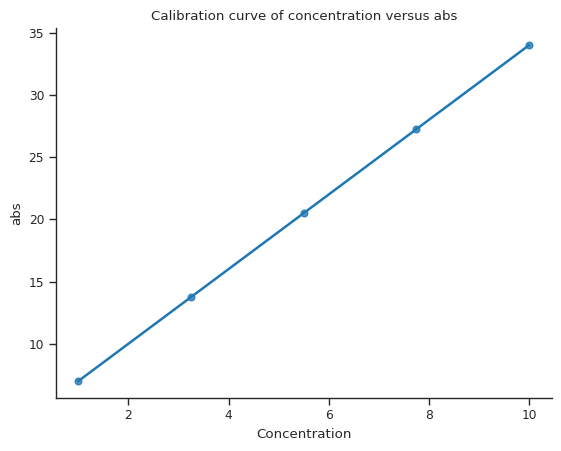

Calibration curve of abs versus concentration
R2 = 1.0
Slope = 3.000000000000001
Intercept = 3.9999999999999964
Uncertainity = 6.662313258790483e-15


In [ ]:
cal = CalibrationModel(data = test_data, sample_data = sample_data, response_variable = "abs", test_replicates = 1)
cal.fit_model()

In [ ]:
assert cal.inverse_prediction('unknown1') == 3.25


In [ ]:
# assert cal.inverse_prediction('unknown2') == 5.5

In [ ]:
cal.sample_data

,abs
sample,
unknown1,13.75
unknown2,20.50


In [ ]:
cal.raw_data

,concentration,abs
0,1.00,7.00
1,3.25,13.75
2,5.50,20.50
3,7.75,27.25
4,10.00,34.00


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()